<a href="https://colab.research.google.com/github/mss423/ACS-LessIsMore/blob/main/Experiments_Driver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.5 MB/s eta 0:00:00
   

Clone GitHub project

In [2]:
import os

# GitHub cloning...
user = "mss423"
repo = "ACS-LessIsMore"

# remove local directory if it already exists
if os.path.isdir(repo):
    !rm -rf {repo}

# clone repo
!git clone https://github.com/{user}/{repo}.git

Cloning into 'ACS-LessIsMore'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 194 (delta 103), reused 134 (delta 53), pack-reused 0 (from 0)
Receiving objects: 100% (194/194), 15.77 MiB | 10.49 MiB/s, done.
Resolving deltas: 100% (103/103), done.


Add codes to pwd

In [3]:
import sys

for dirpath, dirnames, filenames in os.walk("ACS-LessIsMore"):
        sys.path.append(dirpath)

Authenticate notebook for Google packages

In [4]:
# if it's Colab runtime, authenticate the user with Google Cloud
if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

LOCATION = "us-central1"
PROJECT_ID = "synthetic-data-432701"
! gcloud services enable compute.googleapis.com aiplatform.googleapis.com storage.googleapis.com bigquery.googleapis.com --project {PROJECT_ID}

Operation "operations/acat.p2-29476227164-2c4b5a9f-6ae7-407d-b99a-7737dcfb480f" finished successfully.


# Run experiments
## Load Data

In [11]:
from load_data import *
import pandas as pd

datadir = "/content/ACS-LessIsMore/datasets"
savedir = "/content/ACS-LessIsMore/results"
dataset = 'fewrel' # 'fewrel'

# Load data_df, train and test
train_df, num_labels = load_train_data(datadir, dataset)
test_df  = load_test_data(datadir, dataset)

#
num_labels = test_df['label'].nunique()

{'path': '/content/ACS-LessIsMore/datasets/FewRel/train.json', 'data': (12800, 2), 'unique_labels': 64}
{'path': '/content/ACS-LessIsMore/datasets/FewRel/test.json', 'data': (4480, 2), 'unique_labels': 64}


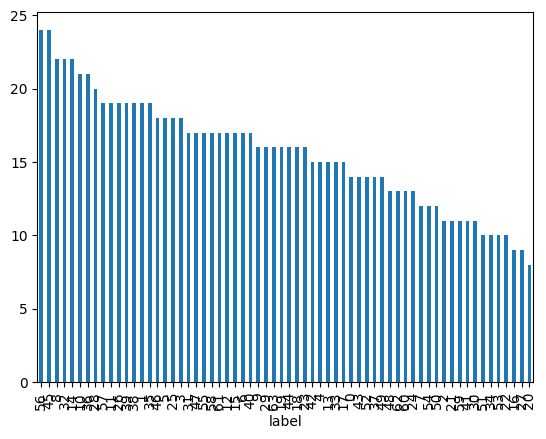

In [12]:
# Downsample train_df to 1000 randomly selected samples for testing
train_df = train_df.sample(n=1000, random_state=42)
if dataset == 'fewrel':
    train_df.label.value_counts().plot(kind='bar')
else:
    test_df = test_df[['sentence', 'label']]

## Run subsampling

In [13]:
from acs import acs_sample

Ks = [len(train_df)//10]
train_subsample_idx = acs_sample(train_df, Ks)
results_df = pd.DataFrame(columns=['K','acc','f1'])

100%|██████████| 63/63 [00:15<00:00,  4.18it/s]


## Train BERT model

In [14]:
from train_model import train_bert, Metric, run_bert_train
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

results = []
num_reps = 1
for K in Ks:
    k_samples = train_subsample_idx[K]
    num_train_samples = int(0.9 * K)
    train_idx = k_samples[:num_train_samples]

    train_samples = train_df.iloc[train_idx]
    dev_samples = train_df.iloc[k_samples[num_train_samples:]]

    for i in range(num_reps):
        print(f"K: {K}, rep: {i+1}/{num_reps}")
        metrics, acc = train_on_data(train_samples, test_df, num_labels, dataset, seed=42*(i+1))
        # metrics, acc = run_bert_train(train_samples, test_df, num_labels=num_labels, seed=42*(i+1))
        # test_result = train_bert(train_samples, dev_samples, test_df, num_labels=num_labels, seed=42*(i+1))
        # acc, f1 = Metric(test_df.label, test_result.prediction)
        print(metrics.keys)
        results.append({'K': K, \
                        'acc': acc, \
                        'precision': metrics['macro avg']['precision'], \
                        'recall': metrics['macro avg']['recall'], \
                        'f1': metrics['macro avg']['f1-score']})
        clear_output(wait=True)

# Save results
results_df = pd.DataFrame(results)
print(results_df)
# results_df.to_csv(os.path.join(savedir, f"{dataset}_results.csv"), index=False)

K: 100, rep: 1/1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


====================  Preparing for training  ====================
	* Loading training data...
	* Loading validation data...
	* Loading test data...
	* Building model...
REACHED


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


ValueError: Target size (torch.Size([10])) must be the same as input size (torch.Size([10, 64]))

In [10]:
print(f1)

0.3381553708439898
